<a href="https://colab.research.google.com/github/JuanPabl07DP/Cardiovascular_CNN/blob/main/Cardiovascular_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
import glob
import random
import shutil
from pathlib import Path

# Descargar el dataset
path = kagglehub.dataset_download("danialsharifrazi/cad-cardiac-mri-dataset")
print("Path to dataset files:", path)

# Definir las rutas a las carpetas de imágenes
normal_dir = os.path.join(path, 'Normal')
sick_dir = os.path.join(path, 'Sick')

# Verificar las rutas
print(f"Ruta a imágenes normales: {normal_dir}")
print(f"Ruta a imágenes de pacientes con CAD: {sick_dir}")

100%|██████████| 2.86G/2.86G [02:19<00:00, 22.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/danialsharifrazi/cad-cardiac-mri-dataset/versions/2
Ruta a imágenes normales: /root/.cache/kagglehub/datasets/danialsharifrazi/cad-cardiac-mri-dataset/versions/2/Normal
Ruta a imágenes de pacientes con CAD: /root/.cache/kagglehub/datasets/danialsharifrazi/cad-cardiac-mri-dataset/versions/2/Sick


In [2]:
# Función para obtener todas las rutas de imágenes de un directorio
def get_image_paths(directory):
    image_paths = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        image_paths.extend(glob.glob(os.path.join(directory, '**', ext), recursive=True))
    return image_paths

# Obtener todas las rutas de imágenes
normal_paths = get_image_paths(normal_dir)
sick_paths = get_image_paths(sick_dir)

print(f"Encontradas {len(normal_paths)} imágenes normales")
print(f"Encontradas {len(sick_paths)} imágenes con CAD")

# Balancear el dataset usando todas las imágenes de la clase minoritaria
min_count = min(len(normal_paths), len(sick_paths))
print(f"Para balancear las clases, usaremos {min_count} imágenes de cada clase")

# Seleccionar subconjuntos balanceados
if len(normal_paths) > min_count:
    random.seed(42)
    normal_paths = random.sample(normal_paths, min_count)

if len(sick_paths) > min_count:
    random.seed(42)
    sick_paths = random.sample(sick_paths, min_count)

print(f"Imágenes normales a procesar: {len(normal_paths)}")
print(f"Imágenes CAD a procesar: {len(sick_paths)}")

Encontradas 37564 imágenes normales
Encontradas 25861 imágenes con CAD
Para balancear las clases, usaremos 25861 imágenes de cada clase
Imágenes normales a procesar: 25861
Imágenes CAD a procesar: 25861


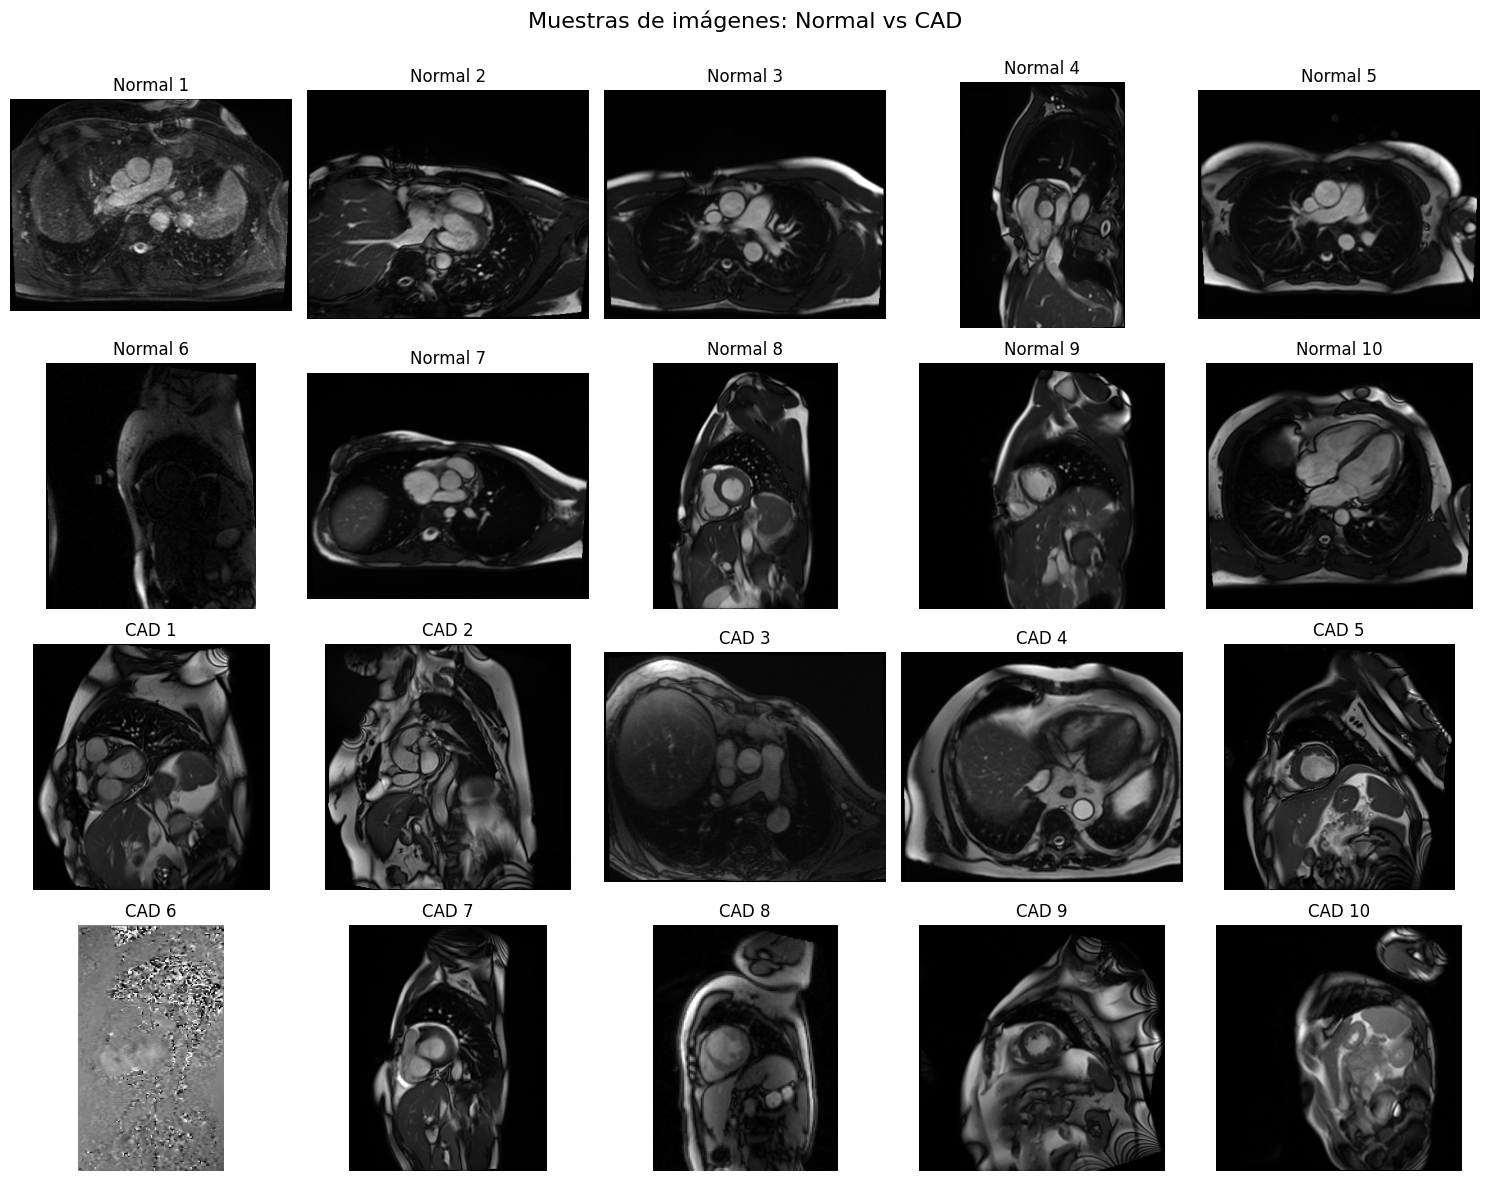

Tamaño de imagen (ejemplo): (512, 384)


In [3]:
# Seleccionar aleatoriamente 10 imágenes de cada clase para visualización
random.seed(42)  # Para reproducibilidad
sample_normal_paths = random.sample(normal_paths, 10)
sample_sick_paths = random.sample(sick_paths, 10)

# Configurar la visualización en una cuadrícula de 4x5 (10 imágenes por clase)
plt.figure(figsize=(15, 12))

# Visualizar imágenes normales
for i, img_path in enumerate(sample_normal_paths):
    plt.subplot(4, 5, i + 1)
    img = Image.open(img_path)
    img_array = np.array(img)
    plt.imshow(img_array, cmap='gray' if len(img_array.shape) == 2 else None)
    plt.title(f"Normal {i+1}")
    plt.axis('off')

# Visualizar imágenes CAD
for i, img_path in enumerate(sample_sick_paths):
    plt.subplot(4, 5, i + 11)  # Empezar en la segunda fila (índice 11)
    img = Image.open(img_path)
    img_array = np.array(img)
    plt.imshow(img_array, cmap='gray' if len(img_array.shape) == 2 else None)
    plt.title(f"CAD {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Muestras de imágenes: Normal vs CAD", fontsize=16)
plt.subplots_adjust(top=0.92)  # Ajustar para dejar espacio al título
plt.show()

# Opcional: Imprimir información sobre el tamaño y formato de las imágenes
sample_img = Image.open(sample_normal_paths[0])
print(f"Tamaño de imagen (ejemplo): {sample_img.size}")

In [4]:
# Combinar y mezclar todas las rutas
all_paths = normal_paths + sick_paths
all_labels = [0] * len(normal_paths) + [1] * len(sick_paths)

# Mezclar los datos
combined = list(zip(all_paths, all_labels))
random.seed(42)
random.shuffle(combined)
all_paths, all_labels = zip(*combined)

# Dividir en conjuntos de entrenamiento, validación y prueba (70/15/15)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_paths, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"Train: {len(train_paths)} imágenes ({len(train_paths)/len(all_paths):.2%})")
print(f"Validación: {len(val_paths)} imágenes ({len(val_paths)/len(all_paths):.2%})")
print(f"Test: {len(test_paths)} imágenes ({len(test_paths)/len(all_paths):.2%})")

Train: 36205 imágenes (70.00%)
Validación: 7758 imágenes (15.00%)
Test: 7759 imágenes (15.00%)


In [5]:
# Crear un generador de datos personalizado
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size=32, img_size=(128, 128), shuffle=True, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

        # Crear generador para aumento de datos si es necesario
        if self.augment:
            self.datagen = ImageDataGenerator(
                rotation_range=15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True,
                fill_mode='nearest'
            )

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        batch_x = []
        batch_y = []

        for i in batch_indexes:
            img_path = self.image_paths[i]
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(self.img_size)
                img_array = np.array(img) / 255.0

                batch_x.append(img_array)
                batch_y.append(self.labels[i])
            except Exception as e:
                print(f"Error procesando {img_path}: {e}")
                continue

        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)

        # Aplicar aumento de datos si está habilitado
        if self.augment and len(batch_x) > 0:
            for i in range(len(batch_x)):
                if np.random.rand() < 0.5:  # Aumento de datos aleatorio
                    params = self.datagen.get_random_transform(batch_x[i].shape)
                    batch_x[i] = self.datagen.apply_transform(batch_x[i], params)

        return batch_x, batch_y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Crear generadores para entrenamiento, validación y prueba
batch_size = 32
img_size = (128, 128)

train_generator = DataGenerator(
    train_paths, train_labels,
    batch_size=batch_size,
    img_size=img_size,
    shuffle=True,
    augment=True  # Solo aplicar aumento de datos al conjunto de entrenamiento
)

val_generator = DataGenerator(
    val_paths, val_labels,
    batch_size=batch_size,
    img_size=img_size,
    shuffle=False,
    augment=False
)

test_generator = DataGenerator(
    test_paths, test_labels,
    batch_size=batch_size,
    img_size=img_size,
    shuffle=False,
    augment=False
)

In [6]:
# Definir el modelo CNN
def create_cnn_model(input_shape=(128, 128, 3)):
    model = Sequential([
        # Primera capa convolucional
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Segunda capa convolucional
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Tercera capa convolucional
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Cuarta capa convolucional
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Flatten y capas densas
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Salida binaria (CAD o normal)
    ])

    # Compilar el modelo
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

# Crear y mostrar el resumen del modelo
model = create_cnn_model(input_shape=(img_size[0], img_size[1], 3))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,405,217 (20.62 MB)

 Trainable params: 5,402,529 (20.61 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [7]:
# Definir callbacks para el entrenamiento
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1),
    ModelCheckpoint('/kaggle/working/best_cardiac_cad_cnn_model.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)
]

# Añadir pesos de clase para dar más importancia a la detección de CAD
class_weights = {0: 1.0, 1: 2.0}  # Dar más peso a la clase CAD para mejorar el recall

# Entrenar el modelo con los generadores (sin los argumentos problemáticos)
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights
)

# Evaluar con el conjunto de prueba
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Guardar el modelo final
model.save("/kaggle/working/cardiac_cad_cnn_model_final.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5970 - auc: 0.6386 - loss: 1.2158 - precision: 0.5837 - recall: 0.6532
Epoch 1: val_auc improved from -inf to 0.79684, saving model to /kaggle/working/best_cardiac_cad_cnn_model.h5


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 252s 204ms/step - accuracy: 0.5971 - auc: 0.6387 - loss: 1.2157 - precision: 0.5837 - recall: 0.6533 - val_accuracy: 0.5000 - val_auc: 0.7968 - val_loss: 1.8896 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7026 - auc: 0.7806 - loss: 0.8522 - precision: 0.6598 - recall: 0.8319
Epoch 2: val_auc improved from 0.79684 to 0.90230, saving model to /kaggle/working/best_cardiac_cad_cnn_model.h5


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 214s 189ms/step - accuracy: 0.7026 - auc: 0.7806 - loss: 0.8522 - precision: 0.6598 - recall: 0.8319 - val_accuracy: 0.5152 - val_auc: 0.9023 - val_loss: 1.4917 - val_precision: 0.5077 - val_recall: 0.9995 - learning_rate: 1.0000e-04
Epoch 3/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7636 - auc: 0.8535 - loss: 0.6805 - precision: 0.7172 - recall: 0.8749
Epoch 3: val_auc improved from 0.90230 to 0.93473, saving model to /kaggle/working/best_cardiac_cad_cnn_model.h5


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 262s 189ms/step - accuracy: 0.7636 - auc: 0.8535 - loss: 0.6805 - precision: 0.7172 - recall: 0.8749 - val_accuracy: 0.5828 - val_auc: 0.9347 - val_loss: 1.0016 - val_precision: 0.5454 - val_recall: 0.9943 - learning_rate: 1.0000e-04
Epoch 4/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7973 - auc: 0.8927 - loss: 0.5808 - precision: 0.7488 - recall: 0.8969
Epoch 4: val_auc improved from 0.93473 to 0.95888, saving model to /kaggle/working/best_cardiac_cad_cnn_model.h5


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 216s 190ms/step - accuracy: 0.7973 - auc: 0.8927 - loss: 0.5808 - precision: 0.7488 - recall: 0.8969 - val_accuracy: 0.7111 - val_auc: 0.9589 - val_loss: 0.6571 - val_precision: 0.6343 - val_recall: 0.9972 - learning_rate: 1.0000e-04
Epoch 5/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8281 - auc: 0.9197 - loss: 0.4992 - precision: 0.7785 - recall: 0.9147
Epoch 5: val_auc improved from 0.95888 to 0.97391, saving model to /kaggle/working/best_cardiac_cad_cnn_model.h5


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 209s 185ms/step - accuracy: 0.8281 - auc: 0.9197 - loss: 0.4992 - precision: 0.7785 - recall: 0.9147 - val_accuracy: 0.8775 - val_auc: 0.9739 - val_loss: 0.2735 - val_precision: 0.8157 - val_recall: 0.9755 - learning_rate: 1.0000e-04
Epoch 6/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8451 - auc: 0.9334 - loss: 0.4542 - precision: 0.7991 - recall: 0.9216
Epoch 6: val_auc improved from 0.97391 to 0.98129, saving model to /kaggle/working/best_cardiac_cad_cnn_model.h5


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 209s 185ms/step - accuracy: 0.8451 - auc: 0.9334 - loss: 0.4541 - precision: 0.7991 - recall: 0.9216 - val_accuracy: 0.8862 - val_auc: 0.9813 - val_loss: 0.2577 - val_precision: 0.8223 - val_recall: 0.9853 - learning_rate: 1.0000e-04
Epoch 7/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8643 - auc: 0.9488 - loss: 0.3959 - precision: 0.8224 - recall: 0.9329
Epoch 7: val_auc improved from 0.98129 to 0.98755, saving model to /kaggle/working/best_cardiac_cad_cnn_model.h5


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 210s 185ms/step - accuracy: 0.8643 - auc: 0.9488 - loss: 0.3959 - precision: 0.8224 - recall: 0.9329 - val_accuracy: 0.9148 - val_auc: 0.9876 - val_loss: 0.2052 - val_precision: 0.8598 - val_recall: 0.9912 - learning_rate: 1.0000e-04
Epoch 8/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8796 - auc: 0.9591 - loss: 0.3550 - precision: 0.8363 - recall: 0.9413
Epoch 8: val_auc improved from 0.98755 to 0.98798, saving model to /kaggle/working/best_cardiac_cad_cnn_model.h5


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 213s 188ms/step - accuracy: 0.8796 - auc: 0.9591 - loss: 0.3550 - precision: 0.8363 - recall: 0.9413 - val_accuracy: 0.9352 - val_auc: 0.9880 - val_loss: 0.1567 - val_precision: 0.9046 - val_recall: 0.9729 - learning_rate: 1.0000e-04
Epoch 9/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8881 - auc: 0.9629 - loss: 0.3376 - precision: 0.8486 - recall: 0.9454
Epoch 9: val_auc did not improve from 0.98798
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 218s 192ms/step - accuracy: 0.8881 - auc: 0.9629 - loss: 0.3376 - precision: 0.8486 - recall: 0.9454 - val_accuracy: 0.9163 - val_auc: 0.9878 - val_loss: 0.2057 - val_precision: 0.8654 - val_recall: 0.9861 - learning_rate: 1.0000e-04
Epoch 10/10
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8960 - auc: 0.9679 - loss: 0.3146 - precision: 0.8601 - recall: 0.9468
Epoch 10: val_auc improved from 0.98798 to 0.99141, saving model to /kaggle/working/best_cardiac_cad_cnn_model.h5


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 257s 188ms/step - accuracy: 0.8960 - auc: 0.9679 - loss: 0.3146 - precision: 0.8601 - recall: 0.9468 - val_accuracy: 0.9301 - val_auc: 0.9914 - val_loss: 0.1743 - val_precision: 0.8845 - val_recall: 0.9894 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 8.
243/243 ━━━━━━━━━━━━━━━━━━━━ 27s 111ms/step - accuracy: 0.9283 - auc: 0.9867 - loss: 0.1663 - precision: 0.8960 - recall: 0.9696


Test Loss: 0.1647
Test Accuracy: 0.9277
Test AUC: 0.9872
Test Precision: 0.8942
Test Recall: 0.9701


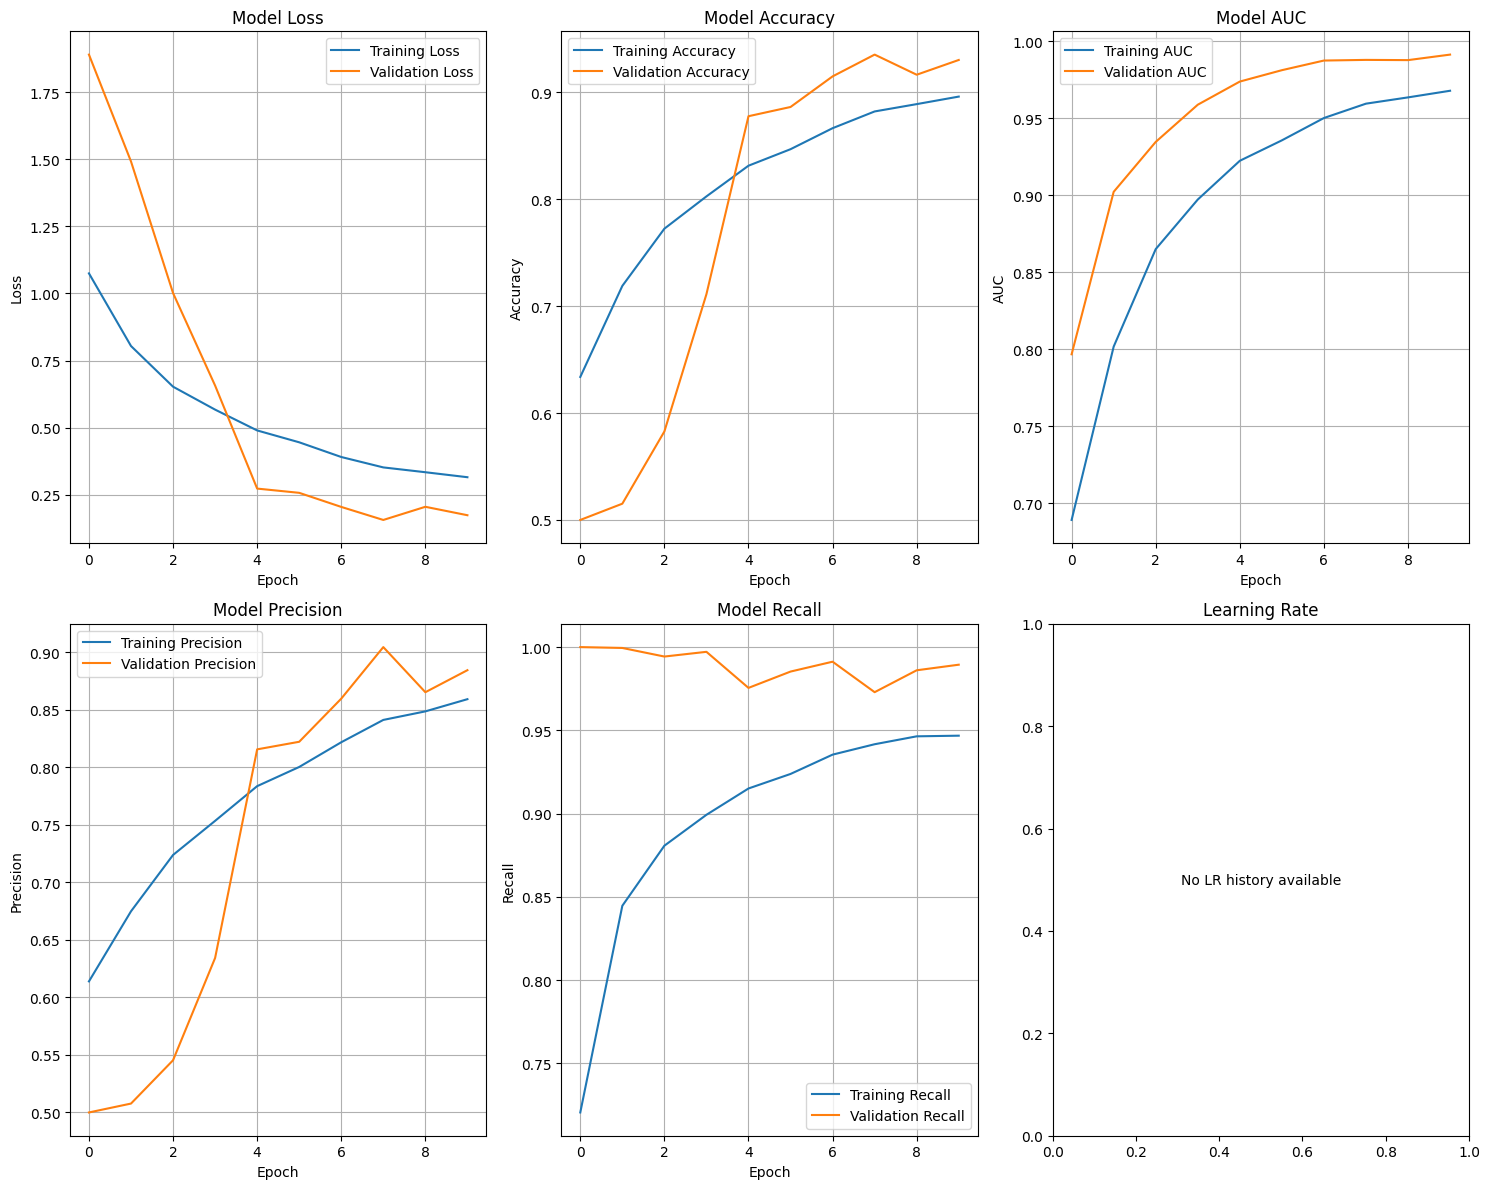

243/243 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step


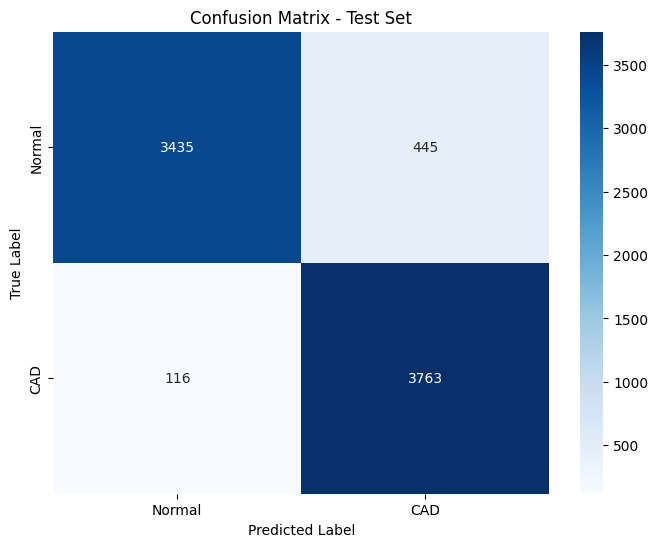

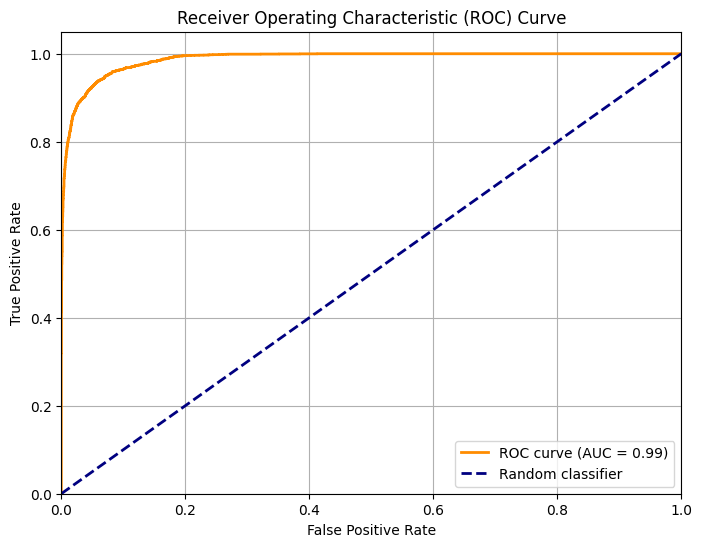

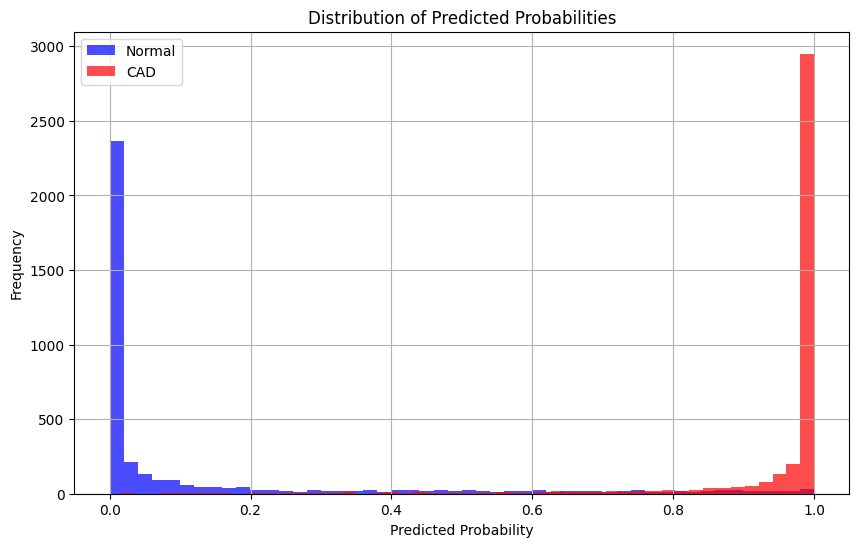

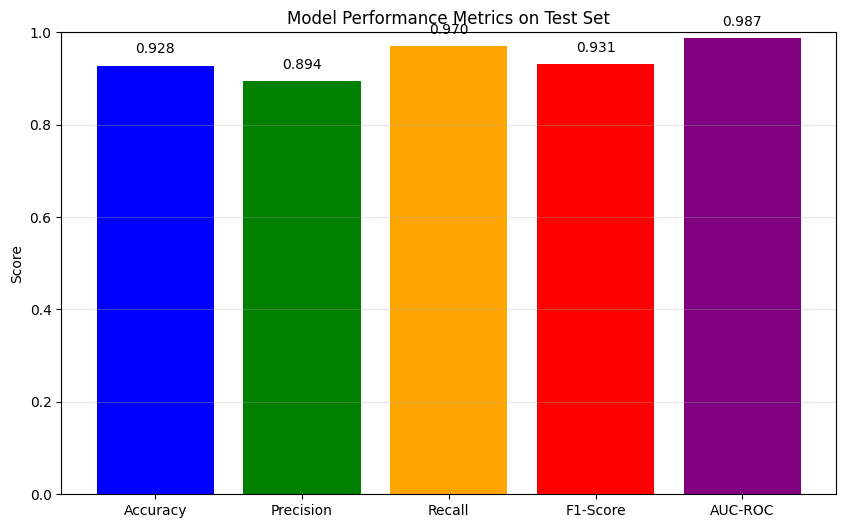

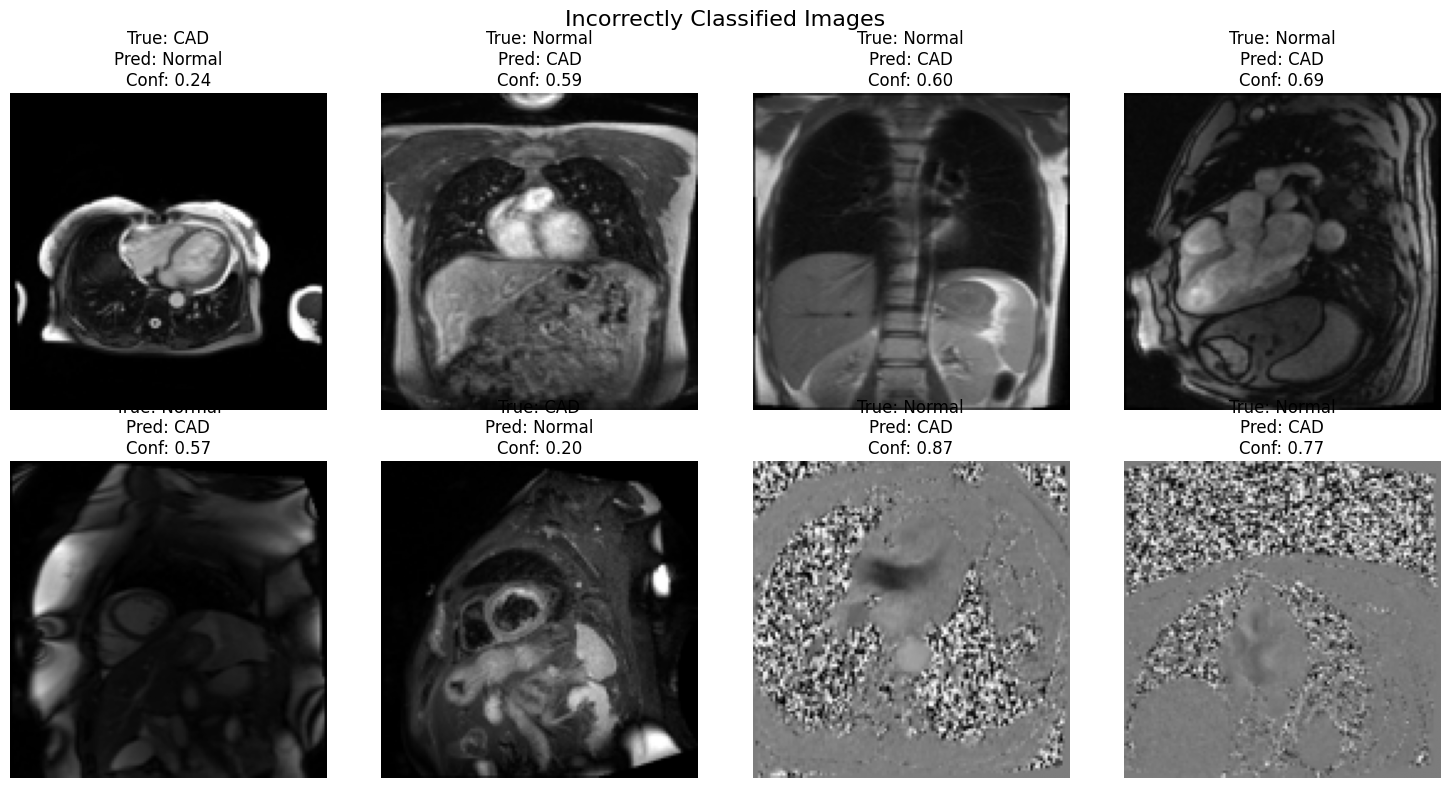


Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.89      0.92      3880
         CAD       0.89      0.97      0.93      3879

    accuracy                           0.93      7759
   macro avg       0.93      0.93      0.93      7759
weighted avg       0.93      0.93      0.93      7759


Final Test Metrics Summary:
Test Accuracy: 0.9277
Test AUC: 0.9872
Test Precision: 0.8942
Test Recall: 0.9701
Test Loss: 0.1647
Specificity (Normal detection): 0.8853
Sensitivity (CAD detection): 0.9701


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from tensorflow.keras.models import load_model

# 1. Gráficas del entrenamiento
plt.figure(figsize=(15, 12))

# 1.1 Pérdida
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 1.2 Accuracy
plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 1.3 AUC
plt.subplot(2, 3, 3)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

# 1.4 Precision
plt.subplot(2, 3, 4)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# 1.5 Recall
plt.subplot(2, 3, 5)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# 1.6 Learning Rate (si se redujo)
plt.subplot(2, 3, 6)
if 'lr' in history.history:
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
else:
    plt.text(0.5, 0.5, 'No LR history available', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Learning Rate')

plt.tight_layout()
plt.show()

# 2. Matriz de Confusión del conjunto de prueba
# Generar predicciones para el conjunto de prueba
y_pred_proba = model.predict(test_generator)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()
y_true = []

# Obtener etiquetas reales del generador de prueba
for i in range(len(test_generator)):
    _, batch_labels = test_generator[i]
    y_true.extend(batch_labels)

y_true = np.array(y_true).astype(int)

# Crear matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'CAD'],
            yticklabels=['Normal', 'CAD'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 3. Curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_proba.flatten())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 4. Distribution de probabilidades predichas
plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba[y_true == 0], bins=50, alpha=0.7, label='Normal', color='blue')
plt.hist(y_pred_proba[y_true == 1], bins=50, alpha=0.7, label='CAD', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.grid(True)
plt.show()

# 5. Gráfica de barras con métricas del conjunto de prueba
plt.figure(figsize=(10, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
values = [
    test_acc,
    test_precision,
    test_recall,
    2 * (test_precision * test_recall) / (test_precision + test_recall),  # F1-Score
    test_auc
]

bars = plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Model Performance Metrics on Test Set')
plt.grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{value:.3f}', ha='center', va='bottom')

plt.show()

# 6. Visualización de predicciones incorrectas
# Obtener índices de predicciones incorrectas
incorrect_indices = np.where(y_pred != y_true)[0]

if len(incorrect_indices) > 0:
    # Seleccionar algunas predicciones incorrectas para visualizar
    n_samples = min(8, len(incorrect_indices))
    sample_indices = np.random.choice(incorrect_indices, n_samples, replace=False)

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(sample_indices):
        plt.subplot(2, 4, i + 1)

        # Obtener la imagen
        batch_idx = idx // test_generator.batch_size
        in_batch_idx = idx % test_generator.batch_size
        batch_x, _ = test_generator[batch_idx]

        if in_batch_idx < len(batch_x):
            img = batch_x[in_batch_idx]

            # Mostrar la imagen
            plt.imshow(img)

            # Título con información de la predicción
            true_label = 'CAD' if y_true[idx] == 1 else 'Normal'
            pred_label = 'CAD' if y_pred[idx] == 1 else 'Normal'
            confidence = y_pred_proba[idx][0]

            plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}')
            plt.axis('off')

    plt.suptitle('Incorrectly Classified Images', fontsize=16)
    plt.tight_layout()
    plt.show()

# 7. Reporte de clasificación
print("\nClassification Report:")
print("="*50)
print(classification_report(y_true, y_pred, target_names=['Normal', 'CAD']))

# 8. Resumen de métricas
print(f"\nFinal Test Metrics Summary:")
print("="*30)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Calcular specificity y sensitivity adicionales
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print(f"Specificity (Normal detection): {specificity:.4f}")
print(f"Sensitivity (CAD detection): {sensitivity:.4f}")